## BAN 676 Group Project

### Gender & Mask Detection in Real Time Video Stream

#### Team Members

Subramanian Padmanabhan (LV6503) and 
Prathamesh Rajiv Bhople (YV5392) 

________________________________________________________________________________________________________________________________

#### Gender Detection Model

In [1]:
# Import Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
# Setting Initial parameters
epochs = 10
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

In [3]:
# Loading both gender images files from the dataset stored after web scraping
data = []
labels = []
image_files = [f for f in glob.glob(r'C:\BAN_676\Group_Project\Gender\archive\Training' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# Converting images to arrays and labelling the categories 'female' and 'male'
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)
    label = img.split(os.path.sep)[-2]
    if label == "female":
        label = 1
    else:
        label = 0        
    labels.append([label])

In [5]:
# Data pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [6]:
# Using Data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.15,
                         height_shift_range=0.15, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [7]:
# Define Gender detection model

def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid")) # because 2 categories, 'female' or 'male'

    return model

In [8]:
# Building model
model1 = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)
# Compiling the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
# Print model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

In [9]:
# Training the model
H_history = model1.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX,testY), steps_per_epoch=len(trainX) // batch_size, epochs=epochs, verbose=1)

C:\Users\STSC\AppData\Local\Temp/ipykernel_23044/1382501960.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H_history = model1.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX,testY), steps_per_epoch=len(trainX) // batch_size, epochs=epochs, verbose=1)


Epoch 1/10
202/202 [==============================] - 138s 677ms/step - loss: 0.5861 - accuracy: 0.7568 - val_loss: 1.8593 - val_accuracy: 0.4966
Epoch 2/10
202/202 [==============================] - 134s 664ms/step - loss: 0.3449 - accuracy: 0.8626 - val_loss: 0.6001 - val_accuracy: 0.7028
Epoch 3/10
202/202 [==============================] - 127s 627ms/step - loss: 0.2517 - accuracy: 0.9004 - val_loss: 0.2602 - val_accuracy: 0.9035
Epoch 4/10
202/202 [==============================] - 139s 687ms/step - loss: 0.2168 - accuracy: 0.9148 - val_loss: 0.3319 - val_accuracy: 0.8751
Epoch 5/10
202/202 [==============================] - 164s 814ms/step - loss: 0.2048 - accuracy: 0.9211 - val_loss: 0.3438 - val_accuracy: 0.8738
Epoch 6/10
202/202 [==============================] - 145s 719ms/step - loss: 0.1921 - accuracy: 0.9294 - val_loss: 0.1489 - val_accuracy: 0.9490
Epoch 7/10
202/202 [==============================] - 137s 679ms/step - loss: 0.1730 - accuracy: 0.9360 - val_loss: 0.1717 -

In [10]:
# Saving the gender detection model to disk
model1.save('C:\BAN_676\Group_Project\Gender\gender_detection.model')

INFO:tensorflow:Assets written to: C:\BAN_676\Group_Project\Gender\gender_detection.model\assets


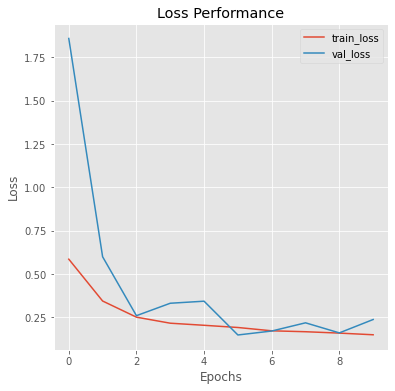

In [11]:
# Plotting training and validation loss performance
plt.style.use("ggplot")
plt.figure(figsize=(6,6))
N = epochs
plt.plot(np.arange(0,N), H_history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H_history.history["val_loss"], label="val_loss")

plt.title("Loss Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('C:\BAN_676\Group_Project\Gender\plot_loss.png')

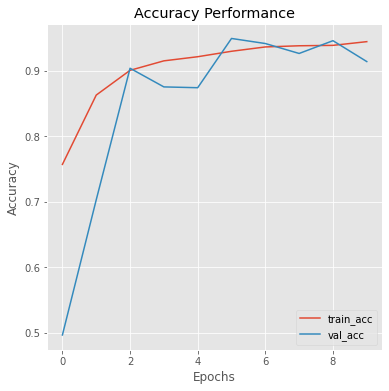

In [12]:
# Plotting the training and validation accuracy performance
plt.style.use("ggplot")
plt.figure(figsize=(6,6))
N = epochs
plt.plot(np.arange(0,N), H_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H_history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# Saving plot to disk
plt.savefig('C:\BAN_676\Group_Project\Gender\plot_accuracy.png')

________________________________________________________________________________________________________________________________

#### Face Mask Detector : Alternative Model

In [13]:
# Initialize the number of epochs to train and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [14]:
# Defining path and categories of mask/no mask dataset
DIRECTORY = r"C:\BAN_676\Group_Project\Facemask\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset\train"
CATEGORIES = ["with_mask", "without_mask"]

In [15]:
# Fetching the list of images in the dataset directory, then initialize
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [16]:
# Performing one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [17]:
# Using Data Augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, 
                         height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [18]:
# For facemask detection, we are using the MobileNetV2 pre-trained basemodel
# Setting the basemodel
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [19]:
# Building the model.
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [20]:
# Place the head model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [21]:
# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [22]:
# Compiling model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
# Training model
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 73s 745ms/step - loss: 0.4031 - accuracy: 0.8487 - val_loss: 0.1373 - val_accuracy: 0.9844
Epoch 2/20
95/95 [==============================] - 70s 737ms/step - loss: 0.1468 - accuracy: 0.9661 - val_loss: 0.0737 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 71s 741ms/step - loss: 0.0964 - accuracy: 0.9726 - val_loss: 0.0538 - val_accuracy: 0.9896
Epoch 4/20
95/95 [==============================] - 69s 729ms/step - loss: 0.0734 - accuracy: 0.9812 - val_loss: 0.0412 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 64s 671ms/step - loss: 0.0690 - accuracy: 0.9809 - val_loss: 0.0387 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 62s 649ms/step - loss: 0.0552 - accuracy: 0.9838 - val_loss: 0.0329 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 62s 651ms/step - loss: 0.0565 - accuracy: 0.9832 - val_loss: 0.0313 - val_accuracy: 0.9922

In [24]:
# Making predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)
# Finding the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# Printing Classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [25]:
# Saving the alternative model for face mask detection to disk
model.save("C:\BAN_676\Group_Project\Facemask\mask_detector.model", save_format="h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


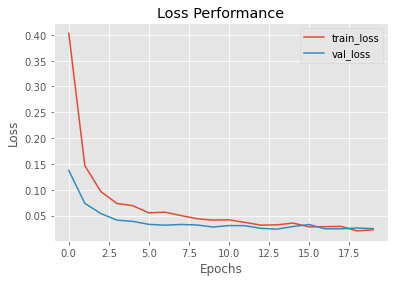

In [26]:
# Plotting the training and validation loss performance
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Loss Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
# Saving plot
plt.savefig("C:\BAN_676\Group_Project\Facemask\plot_loss.png")

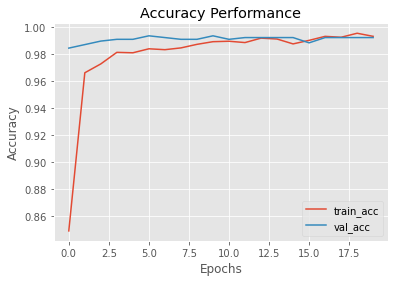

In [27]:
# Plotting the training and validation accuracy performance
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig("C:\BAN_676\Group_Project\Facemask\plot_accuracy.png")

________________________________________________________________________________________________________________________________

#### Face Mask Detector : CNN Model

In [28]:
# Defining paths for training and validation images
train_path = 'C:/BAN_676/Group_Project/Facemask/Face-Mask-Detection-master/Face-Mask-Detection-master/dataset/train'
valid_path = 'C:/BAN_676/Group_Project/Facemask/Face-Mask-Detection-master/Face-Mask-Detection-master/dataset/valid'

In [29]:
# Defining function to plot images 
def PlotImage(img_arr):
    fig,axes = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [30]:
# Performing Data Augmentation for training data
training_datagen = ImageDataGenerator( rescale=1/255 , rotation_range=40 , width_shift_range=0.2 , height_shift_range=0.2 , shear_range=0.2 , zoom_range=0.2 , horizontal_flip=True , fill_mode='nearest' )
training_data= training_datagen.flow_from_directory(train_path , target_size=(224,224) , batch_size=128 , class_mode='binary' )

Found 3833 images belonging to 2 classes.


In [31]:
# Performing Data Augmentation for validation data
valid_datagen = ImageDataGenerator(rescale=1/255)
valid_data= training_datagen.flow_from_directory(valid_path , target_size=(224,224) , batch_size=128 , class_mode='binary' )

Found 806 images belonging to 2 classes.


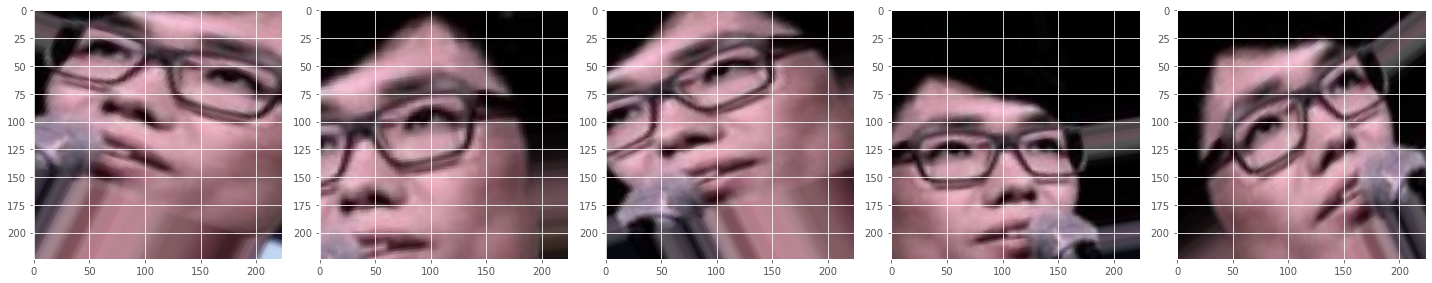

In [32]:
# Plotting random image
images = [training_data[0][0][0] for i in range(5)]
PlotImage(images)

In [33]:
# Building the model

model_cnn = keras.models.Sequential([
keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[224, 224, 3]),
keras.layers.MaxPooling2D(pool_size=(2,2)),
keras.layers.Conv2D(filters=64, kernel_size=3),
keras.layers.MaxPooling2D(pool_size=(2,2)),
keras.layers.Conv2D(filters=128, kernel_size=3),
keras.layers.MaxPooling2D(pool_size=(2,2)),                                    
keras.layers.Conv2D(filters=256, kernel_size=3),
keras.layers.MaxPooling2D(pool_size=(2,2)),

keras.layers.Dropout(0.5),                                                                        
keras.layers.Flatten(),
keras.layers.Dense(units=128, activation='relu'), 
keras.layers.Dropout(0.1),                                    
keras.layers.Dense(units=256, activation='relu'),                                    
keras.layers.Dropout(0.25),                                    
keras.layers.Dense(units=2, activation='softmax')
])

In [34]:
# Compiling the model
model_cnn.compile(optimizer='adam' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])
# Printing the model
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [35]:
# Training the model
history_cnn = model_cnn.fit(training_data ,epochs=20 , verbose=1, validation_data= valid_data)

Epoch 1/20
20/30 [===================>..........] - ETA: 47s - loss: 0.7225 - accuracy: 0.6964

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


30/30 [==============================] - 247s 8s/step - loss: 0.6219 - accuracy: 0.7451 - val_loss: 0.3567 - val_accuracy: 0.8660
Epoch 2/20
30/30 [==============================] - 230s 8s/step - loss: 0.3525 - accuracy: 0.8656 - val_loss: 0.3527 - val_accuracy: 0.8672
Epoch 3/20
30/30 [==============================] - 244s 8s/step - loss: 0.3183 - accuracy: 0.8782 - val_loss: 0.2632 - val_accuracy: 0.8983
Epoch 4/20
30/30 [==============================] - 244s 8s/step - loss: 0.2758 - accuracy: 0.9027 - val_loss: 0.2641 - val_accuracy: 0.9007
Epoch 5/20
30/30 [==============================] - 209s 7s/step - loss: 0.3062 - accuracy: 0.8860 - val_loss: 0.2824 - val_accuracy: 0.9007
Epoch 6/20
30/30 [==============================] - 209s 7s/step - loss: 0.2614 - accuracy: 0.9016 - val_loss: 0.2629 - val_accuracy: 0.9007
Epoch 7/20
30/30 [==============================] - 216s 7s/step - loss: 0.2449 - accuracy: 0.9063 - val_loss: 0.2313 - val_accuracy: 0.9119
Epoch 8/20
30/30 [======

In [36]:
# Saving the CNN face mask detection model to disk
model_cnn.save("C:\BAN_676\Group_Project\Facemask\mask_detector_cnn.model", save_format="h5")

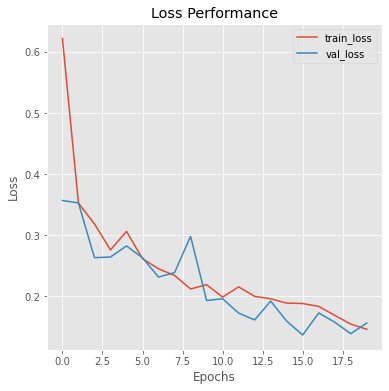

In [37]:
# Plotting training and validation loss performance
plt.style.use("ggplot")
plt.figure(figsize=(6,6))
N = 20
plt.plot(np.arange(0,N), history_cnn.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history_cnn.history["val_loss"], label="val_loss")

plt.title("Loss Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
# Saving plot to disk
plt.savefig("C:\BAN_676\Group_Project\Facemask\plot_loss_cnn.png")

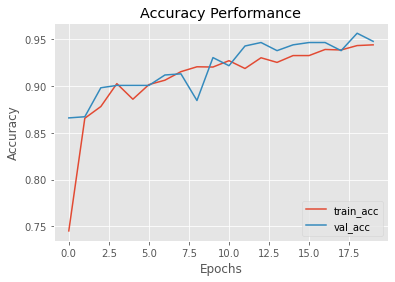

In [38]:
# Plotting training and validation accuracy performance
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_cnn.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history_cnn.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig("C:\BAN_676\Group_Project\Facemask\plot_accuracy_cnn.png")

________________________________________________________________________________________________________________________________

#### Image Web Scraping

Following are some URL's we referred to scrape/download the images:

https://unsplash.com/s/photos/man-with-mask , 
https://www.shutterstock.com/search/woman+mask , 
https://unsplash.com/s/photos/men , 
https://www.istockphoto.com/search/2/image?phrase=men , 
https://www.canstockphoto.com/images-photos/men.html , 
https://www.gettyimages.com/photos/surgical-mask , 
https://drive.google.com/drive/folders/1QtnJAeauCqEBIRP_7oyyZF0xRv8dVcDq , 
https://www.gettyimages.com/photos/people-wearing-face-masksassettype=image&sort=mostpopular&phrase=people%20wearing%20face%20masks&license=rf%2Crm , 
https://www.dreamstime.com/photos-images/wear-mask.html , 
https://unsplash.com/s/photos/woman-face-close-up

In [ ]:
import requests
from bs4 import BeautifulSoup
import os

url='https://unsplash.com/s/photos/man-with-mask'

r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

images = soup.find_all('img')
count=1
for image in images:
    print(image['src'])
    count=count+1
    link = image['src']
    with open(str(count) + '.jpg', 'wb') as f:
        im = requests.get(link)
        f.write(im.content)
        print('Writing: ', count)